In [16]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
from dotenv import load_dotenv
from pyproj import Transformer
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import folium
import cv2

In [18]:
load_dotenv()  # charge automatiquement le .env du dossier courant

True

In [19]:
list_bbox_centers = [(43.52960344286241, 5.448962145567533),
(48.092094070852475, -1.7036876101196967),
 (48.121222106840435, -1.602864906604979),
 (45.74557103359813, 4.803091960652229),
 (47.8776770361181, -3.909947991759771),
 (44.55378060775165, 4.28389205759154),
 (45.69764498502806, 5.8945655967385315),
 (48.07500134978729, 7.3491231648955155),
 (50.63412206750312, 3.0435779303880106),
 (44.83078182200822, 0.5108123933396876)]

In [20]:
from urban_watch.ml_logic.data import RAW_DATA_DIR
print(RAW_DATA_DIR)

/home/k2805/code/augustinlafond/project_urban_watch/raw_data


In [21]:
from urban_watch.ml_logic.data import make_bbox_global, get_data

data = get_data(list_bbox_centers)

📡 Downloading tile 0 at 43.52960344286241,5.448962145567533 ...
✔ Saved tile 0 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_0
📡 Downloading tile 1 at 48.092094070852475,-1.7036876101196967 ...
✔ Saved tile 1 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_1
📡 Downloading tile 2 at 48.121222106840435,-1.602864906604979 ...
✔ Saved tile 2 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_2
📡 Downloading tile 3 at 45.74557103359813,4.803091960652229 ...
✔ Saved tile 3 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_3
📡 Downloading tile 4 at 47.8776770361181,-3.909947991759771 ...
✔ Saved tile 4 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_4
📡 Downloading tile 5 at 44.55378060775165,4.28389205759154 ...
✔ Saved tile 5 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_5
📡 Downloading tile 6 at 45.69764498502806,5.8945655967385315 ...
✔ Saved tile 6 in /home/k2805/c

In [22]:
from urban_watch.ml_logic.data import load_data
from s2cloudless import S2PixelCloudDetector
from urban_watch.ml_logic.package import CloudMasker
X, meta = load_data()
print("shape de x:", X.shape)
print("Nombre de NaN dans X brut :", np.isnan(X).sum())

shape de x: (10, 300, 300, 10)
Nombre de NaN dans X brut : 0


In [27]:
from urban_watch.ml_logic.package import preprocess_image
img = X[0]
X_preproc = preprocess_image(img)  # remove_nan=False pour voir si NaN reste
print("Nombre de NaN après preprocessing :", np.isnan(X_preproc).sum())

Nombre de NaN après preprocessing : 0


In [25]:
print(X_preproc[:5])

[[ 0.72894428  1.11544327  0.87241917  0.53336104  0.40924513 -1.18741768
  -1.35402757 -1.60616837 -0.47444255  0.06537301 -1.58050604  0.97690782
   1.71098639]
 [ 0.72894428  1.1821634   0.74712887  0.44947213 -0.15699861 -1.03794358
  -1.05753917 -1.2726877  -0.52229412 -0.2993635  -1.2298243   0.59039019
   1.60776268]
 [ 0.72894428  0.18649377 -0.03245496 -0.11761772 -0.15699861 -1.03794358
  -0.51051825 -1.2726877  -0.52229412 -0.2993635  -0.22597314  0.01950552
   0.49367392]
 [ 0.06187624 -0.89385889 -0.95821083 -0.94644091 -0.90321131 -0.63637156
  -0.54016697 -0.42399779 -0.52400317 -0.84871939  0.9113297   0.04681845
  -1.03753095]
 [ 0.06187624 -1.10428391 -1.11134338 -1.07059661 -0.90321131 -0.63637156
  -0.39192303 -0.42399779 -0.52400317 -0.84871939  1.17416867 -0.09671165
  -1.31688379]]


In [ ]:
X_preproc_list = []
for img in X:
    X_proc = preprocess_image(img)
    X_preproc_list.append(X_proc)
X_preproc_all = np.vstack(X_preproc_list) #valable pour le train modele
print("Shape total après preprocessing :", X_preproc_all.shape)
print("Nombre de NaN :", np.isnan(X_preproc_all).sum())

Shape total après preprocessing : (648654, 13)
Nombre de NaN : 0


-----------------------------------------

In [10]:
print("Nombre de NaN après preprocessing :", np.isnan(X_preproc).sum())

Nombre de NaN après preprocessing : 12298


In [13]:
for i in range(X_preproc.shape[2]):
    nan_count = np.isnan(X_preproc[:, :, i]).sum()
    print(f"Bande {i}: {nan_count} NaN")


Bande 0: 946 NaN
Bande 1: 946 NaN
Bande 2: 946 NaN
Bande 3: 946 NaN
Bande 4: 946 NaN
Bande 5: 946 NaN
Bande 6: 946 NaN
Bande 7: 946 NaN
Bande 8: 946 NaN
Bande 9: 946 NaN
Bande 10: 946 NaN
Bande 11: 946 NaN
Bande 12: 946 NaN


In [15]:
band_names = ["B02","B03","B04","B08","B05","B06","B07","B8A","B01","B09","B10","B11","B12"]
for idx, name in enumerate(band_names):
    nan_count = np.isnan(X_preproc[:, :, idx]).sum()
    print(f"{name}: {nan_count} NaN")


B02: 946 NaN
B03: 946 NaN
B04: 946 NaN
B08: 946 NaN
B05: 946 NaN
B06: 946 NaN
B07: 946 NaN
B8A: 946 NaN
B01: 946 NaN
B09: 946 NaN
B10: 946 NaN
B11: 946 NaN
B12: 946 NaN


TEST DU NAN

In [12]:
from urban_watch.ml_logic.package import CloudMasker, DataCleaner, IndexCalculator
masker = CloudMasker(threshold=0.4)
cleaner = DataCleaner()
cloud_mask = masker.detect_clouds(img)
print("Pourcentage de nuages :", masker.get_cloud_percentage(cloud_mask))

Pourcentage de nuages : 36.41111111111111


In [ ]:
img_norm = cleaner.normalize_bands(img)

In [11]:
mask=masker.detect_clouds(img)

In [12]:
cloud_masker = CloudMasker(threshold=0.4)
cloud_pct = cloud_masker.get_cloud_percentage(mask)
print(f"Pourcentage de nuages détectés : {cloud_pct:.2f}%")

Pourcentage de nuages détectés : 36.41%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6328].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6327999830245972].


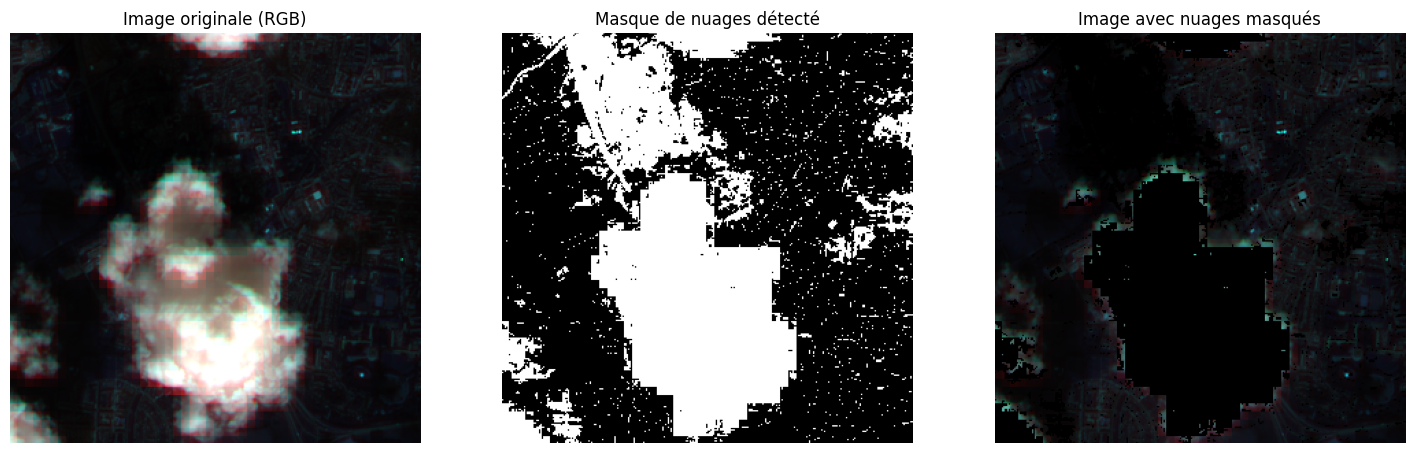

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Image RGB
axs[0].imshow(img[:, :, :3])
axs[0].set_title("Image originale (RGB)")
axs[0].axis("off")

# Masque de nuages
axs[1].imshow(mask, cmap='gray')
axs[1].set_title("Masque de nuages détecté")
axs[1].axis("off")

# Image avec masque appliqué
img_masked = masker.apply_mask(img[:, :, :3], mask)
axs[2].imshow(img_masked)
axs[2].set_title("Image avec nuages masqués")
axs[2].axis("off")

plt.show()

In [14]:
from urban_watch.ml_logic.package import CloudMasker, ImageNormalizer
# Test 1 : Augmente le seuil
masker_high = CloudMasker(threshold=0.6, dilation_size=1)
mask_high = masker_high.detect_clouds(img)
print(f"Avec threshold=0.6 : {masker_high.get_cloud_percentage(mask_high):.2f}%")

# Test 2 : Normalise l'image avant
img_normalized = ImageNormalizer.normalize_full(img)
mask_normalized = masker.detect_clouds(img_normalized)
print(f"Avec normalisation : {masker.get_cloud_percentage(mask_normalized):.2f}%")

# Test 3 : Combiné (normalisé + seuil plus haut)
masker_combined = CloudMasker(threshold=0.6, dilation_size=1)
mask_combined = masker_combined.detect_clouds(img_normalized)
print(f"Avec normalisation + threshold=0.6 : {masker_combined.get_cloud_percentage(mask_combined):.2f}%")

# Affiche aussi la plage de valeurs
print(f"\nMin: {img.min()}, Max: {img.max()}")
print(f"Mean: {img.mean():.2f}, Std: {img.std():.2f}")

Avec threshold=0.6 : 32.43%
Avec normalisation : 33.38%
Avec normalisation + threshold=0.6 : 29.59%

Min: 0.0, Max: 1.6327999830245972
Mean: 0.21, Std: 0.23


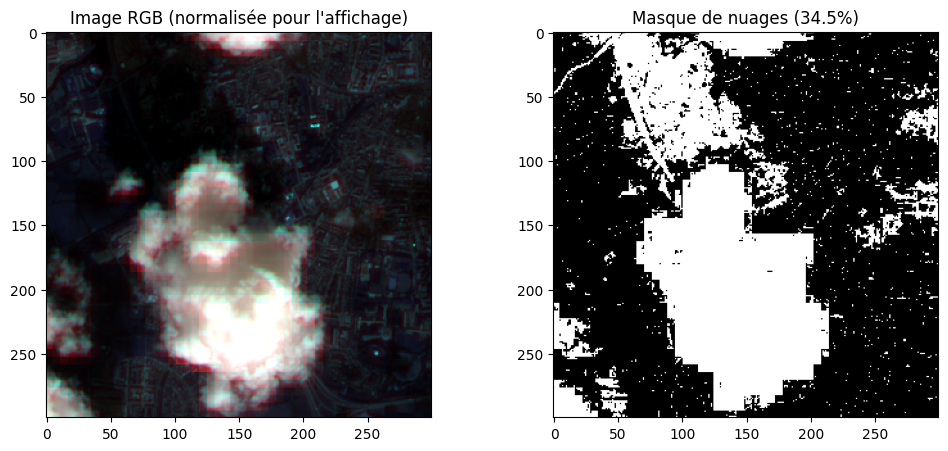

In [15]:
# Cloud detection sur données brutes
masker = CloudMasker(threshold=0.5, dilation_size=1)
mask = masker.detect_clouds(img)  # img en [0-137], pas normalisée

# Après, si tu veux visualiser, normalise pour l'affichage
img_for_display = ImageNormalizer.normalize_full(img)

# Puis affiche
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_for_display[:, :, :3])  # RGB normalisé
axes[0].set_title("Image RGB (normalisée pour l'affichage)")
axes[1].imshow(mask, cmap='gray')
axes[1].set_title(f"Masque de nuages ({masker.get_cloud_percentage(mask):.1f}%)")
plt.show()

In [16]:
# Teste différents thresholds
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    masker_test = CloudMasker(threshold=thresh, dilation_size=1)
    mask_test = masker_test.detect_clouds(img)
    pct = masker_test.get_cloud_percentage(mask_test)
    print(f"threshold={thresh} → {pct:.1f}%")

threshold=0.3 → 38.4%
threshold=0.4 → 36.4%
threshold=0.5 → 34.5%
threshold=0.6 → 32.4%
threshold=0.7 → 30.2%


In [17]:
# Test sans dilation
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    masker_test = CloudMasker(threshold=thresh, dilation_size=0)
    mask_test = masker_test.detect_clouds(img)
    pct = masker_test.get_cloud_percentage(mask_test)
    print(f"threshold={thresh}, dilation=0 → {pct:.1f}%")

threshold=0.3, dilation=0 → 38.4%
threshold=0.4, dilation=0 → 36.4%
threshold=0.5, dilation=0 → 34.5%
threshold=0.6, dilation=0 → 32.4%
threshold=0.7, dilation=0 → 30.2%


In [18]:
# Test avec moins de lissage
for thresh in [0.3, 0.5, 0.7]:
    masker_test = CloudMasker(threshold=thresh, dilation_size=0)
    masker_test.detector.average_over = 1  # Réduis le lissage
    mask_test = masker_test.detect_clouds(img)
    pct = masker_test.get_cloud_percentage(mask_test)
    print(f"threshold={thresh}, dilation=0, average_over=1 → {pct:.1f}%")

threshold=0.3, dilation=0, average_over=1 → 38.4%
threshold=0.5, dilation=0, average_over=1 → 34.5%
threshold=0.7, dilation=0, average_over=1 → 30.2%


Min prob: 0.000, Max prob: 1.000
Mean prob: 0.373, Std prob: 0.400
Unique values: 75051


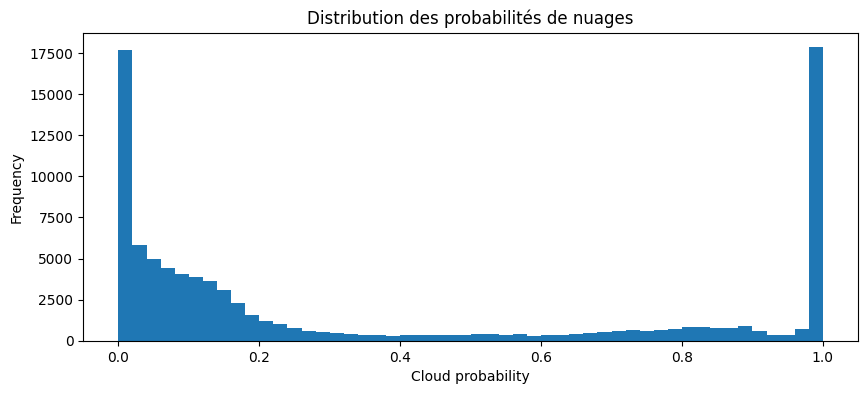

Percentile 10: 0.006
Percentile 25: 0.036
Percentile 50: 0.144
Percentile 75: 0.835
Percentile 90: 1.000
Percentile 95: 1.000


In [19]:
# Regarde la distribution réelle des probabilités
masker_debug = CloudMasker(threshold=0.0, dilation_size=0)
cloud_probs = masker_debug.detector.get_cloud_probability_maps(img[np.newaxis, :, :, :])
probs = cloud_probs[0].flatten()

print(f"Min prob: {probs.min():.3f}, Max prob: {probs.max():.3f}")
print(f"Mean prob: {probs.mean():.3f}, Std prob: {probs.std():.3f}")
print(f"Unique values: {len(np.unique(probs))}")

# Affiche l'histogramme
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(probs, bins=50)
plt.xlabel("Cloud probability")
plt.ylabel("Frequency")
plt.title("Distribution des probabilités de nuages")
plt.show()

# Vérifie les percentiles
for p in [10, 25, 50, 75, 90, 95]:
    print(f"Percentile {p}: {np.percentile(probs, p):.3f}")

In [20]:
masker = CloudMasker(threshold=0.99, dilation_size=0)
mask = masker.detect_clouds(img)
# Seuls les pixels absolument certains d'être nuages
for i in range(len(X)):
       img_i = X[i]
       masker = CloudMasker(threshold=0.5, dilation_size=0)
       mask = masker.detect_clouds(img_i)
       print(f"Tuile {i}: {masker.get_cloud_percentage(mask):.1f}%")

Tuile 0: 1.1%
Tuile 1: 34.5%
Tuile 2: 73.4%
Tuile 3: 58.3%
Tuile 4: 4.6%
Tuile 5: 0.1%
Tuile 6: 18.3%
Tuile 7: 0.9%
Tuile 8: 85.9%
Tuile 9: 2.2%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.844].


{'lat': 43.52960344286241, 'lon': 5.448962145567533, 'bbox': [696391.1284634634, 4821042.763172116, 699391.1284634634, 4824042.763172116], 'bbox_crs': 'EPSG:32631', 'bands': ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B08', 'B8A', 'B11', 'B12'], 'resolution': 10}


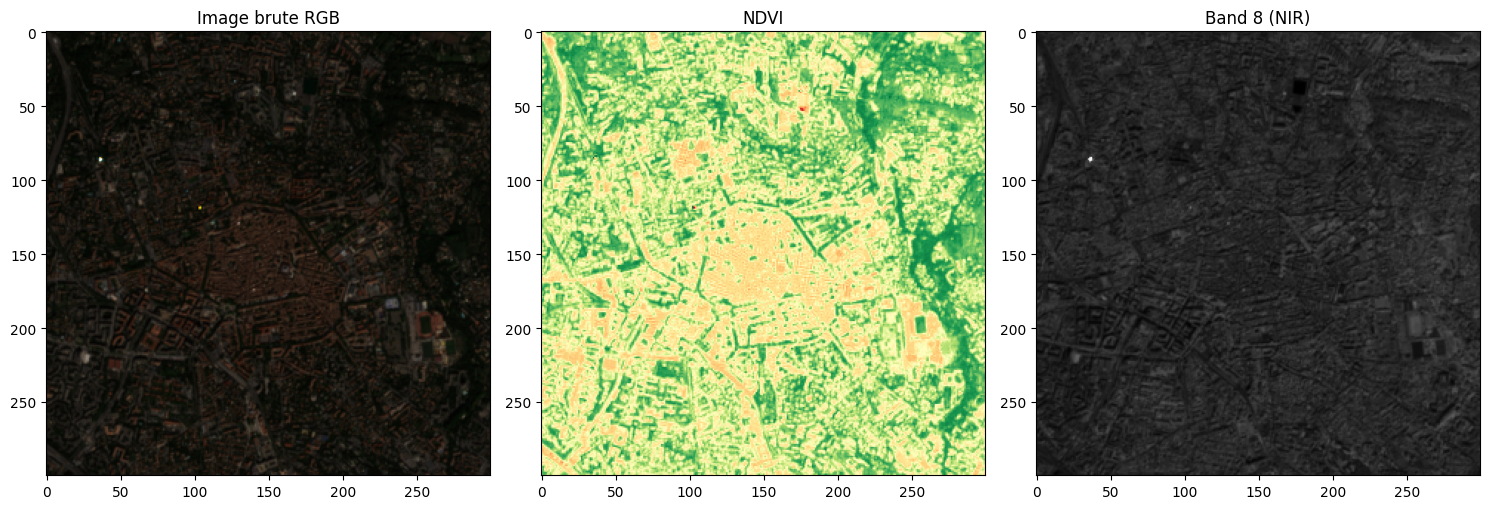

In [21]:
# 1. Affiche les métadonnées
print(meta[0])

# 2. Regarde l'image brute (avant cloud detection)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RGB brut
axes[0].imshow(X[0][:,:,[3,2,1]])  # B04, B03, B02 = RGB
axes[0].set_title("Image brute RGB")

# NDVI (végétation)
B4 = X[0][:,:,3]
B8 = X[0][:,:,6]
ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
axes[1].imshow(ndvi, cmap='RdYlGn')
axes[1].set_title("NDVI")

# Near Infrared
axes[2].imshow(X[0][:,:,6], cmap='gray')
axes[2].set_title("Band 8 (NIR)")

plt.tight_layout()
plt.show()

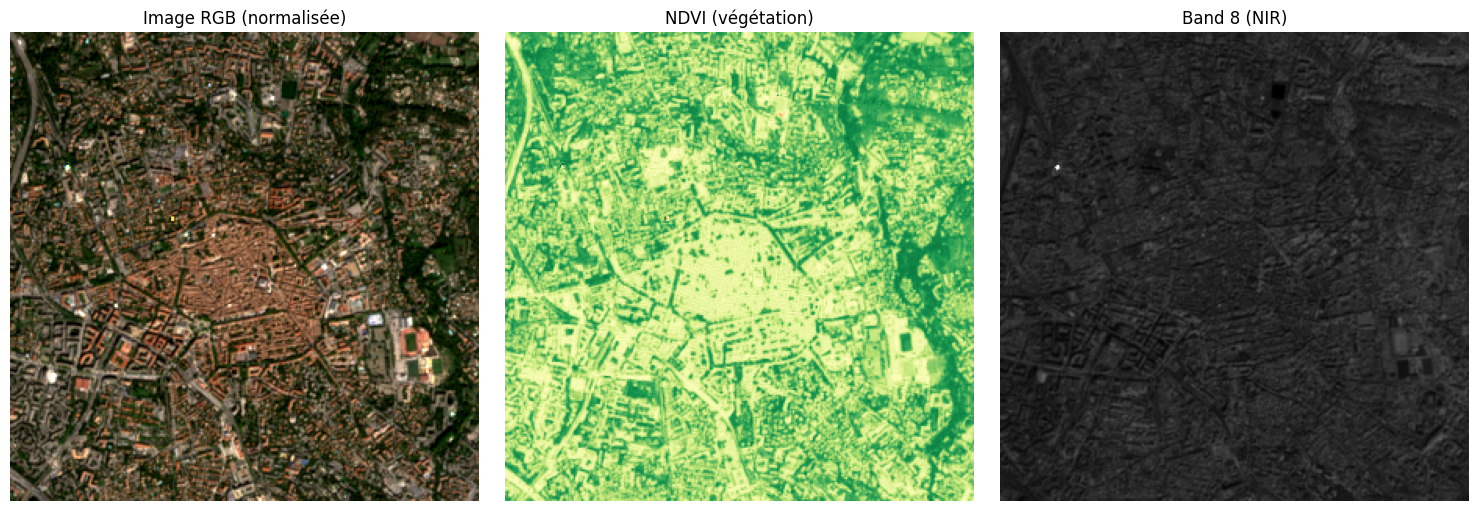

In [22]:
from urban_watch.ml_logic.package import ImageNormalizer

# Charge l'image
img = X[0]

# Normalise pour la visualisation
img_normalized = ImageNormalizer.normalize_full(img)

# Affiche
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RGB normalisé
axes[0].imshow(img_normalized[:, :, [3, 2, 1]])  # B04, B03, B02
axes[0].set_title("Image RGB (normalisée)")
axes[0].axis("off")

# NDVI
B4 = img[:, :, 3].astype(float)
B8 = img[:, :, 6].astype(float)
ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_title("NDVI (végétation)")
axes[1].axis("off")

# NIR
axes[2].imshow(img[:, :, 6], cmap='gray')
axes[2].set_title("Band 8 (NIR)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [23]:
print(f"Shape: {img.shape}")
print(f"Dtype: {img.dtype}")
print(f"Min: {img.min()}, Max: {img.max()}")
print(f"Mean: {img.mean():.2f}, Std: {img.std():.2f}")

# Affiche les stats par bande
for i in range(10):
    print(f"Band {i}: min={img[:,:,i].min()}, max={img[:,:,i].max()}, mean={img[:,:,i].mean():.1f}")

Shape: (300, 300, 10)
Dtype: float32
Min: 0.0, Max: 1.843999981880188
Mean: 0.15, Std: 0.09
Band 0: min=0.006000000052154064, max=0.14419999718666077, mean=0.0
Band 1: min=0.0, max=1.843999981880188, mean=0.1
Band 2: min=0.0, max=1.7416000366210938, mean=0.1
Band 3: min=0.0, max=1.6648000478744507, mean=0.1
Band 4: min=0.0, max=0.5666999816894531, mean=0.1
Band 5: min=0.0, max=0.5634999871253967, mean=0.2
Band 6: min=0.0038999998942017555, max=1.5865000486373901, mean=0.2
Band 7: min=0.0, max=0.5436000227928162, mean=0.2
Band 8: min=0.017100000753998756, max=0.7131999731063843, mean=0.2
Band 9: min=0.014600000344216824, max=0.9764999747276306, mean=0.2


In [24]:
print(meta[0])

{'lat': 43.52960344286241, 'lon': 5.448962145567533, 'bbox': [696391.1284634634, 4821042.763172116, 699391.1284634634, 4824042.763172116], 'bbox_crs': 'EPSG:32631', 'bands': ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B08', 'B8A', 'B11', 'B12'], 'resolution': 10}


Tile 0: 1.1% clouds
Tile 1: 34.5% clouds
Tile 2: 73.4% clouds
Tile 3: 58.3% clouds
Tile 4: 4.6% clouds
Tile 5: 0.1% clouds
Tile 6: 18.3% clouds
Tile 7: 0.9% clouds
Tile 8: 85.9% clouds
Tile 9: 2.2% clouds


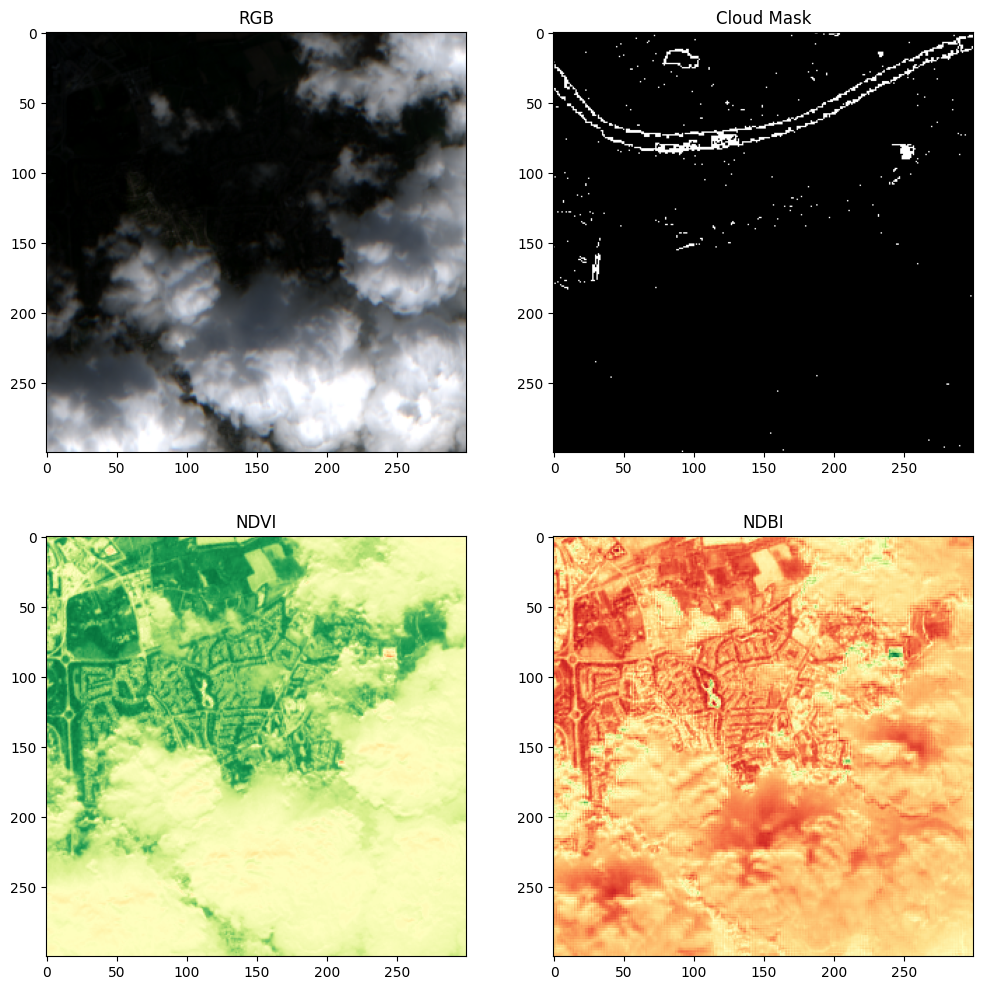

In [25]:
from urban_watch.ml_logic.data import load_data
from urban_watch.ml_logic.package import CloudMasker, IndexCalculator, ImageNormalizer

# 1. Charge les données
X, meta = load_data()  # (10, 300, 300, 10)

# 2. Détecte les nuages
masker = CloudMasker(threshold=0.5, dilation_size=1)
for i, img in enumerate(X):
    mask = masker.detect_clouds(img)
    pct = masker.get_cloud_percentage(mask)
    print(f"Tile {i}: {pct:.1f}% clouds")

# 3. Calcule les indices
img = X[2]
ndvi = IndexCalculator.ndvi(img[:,:,3], img[:,:,6])
ndbi = IndexCalculator.ndbi(img[:,:,8], img[:,:,6])
mndwi = IndexCalculator.mndwi(img[:,:,2], img[:,:,8])

# 4. Normalise pour visualisation
img_norm = ImageNormalizer.normalize_full(img)

# 5. Affiche
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].imshow(img_norm[:,:,[3,2,1]])
axes[0,0].set_title("RGB")
axes[0,1].imshow(mask, cmap='gray')
axes[0,1].set_title("Cloud Mask")
axes[1,0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1,0].set_title("NDVI")
axes[1,1].imshow(ndbi, cmap='RdYlGn')
axes[1,1].set_title("NDBI")
plt.show()

Tile 0: 1.1% clouds
Tile 1: 34.5% clouds
Tile 2: 73.4% clouds
Tile 3: 58.3% clouds
Tile 4: 4.6% clouds
Tile 5: 0.1% clouds
Tile 6: 18.3% clouds
Tile 7: 0.9% clouds
Tile 8: 85.9% clouds
Tile 9: 2.2% clouds


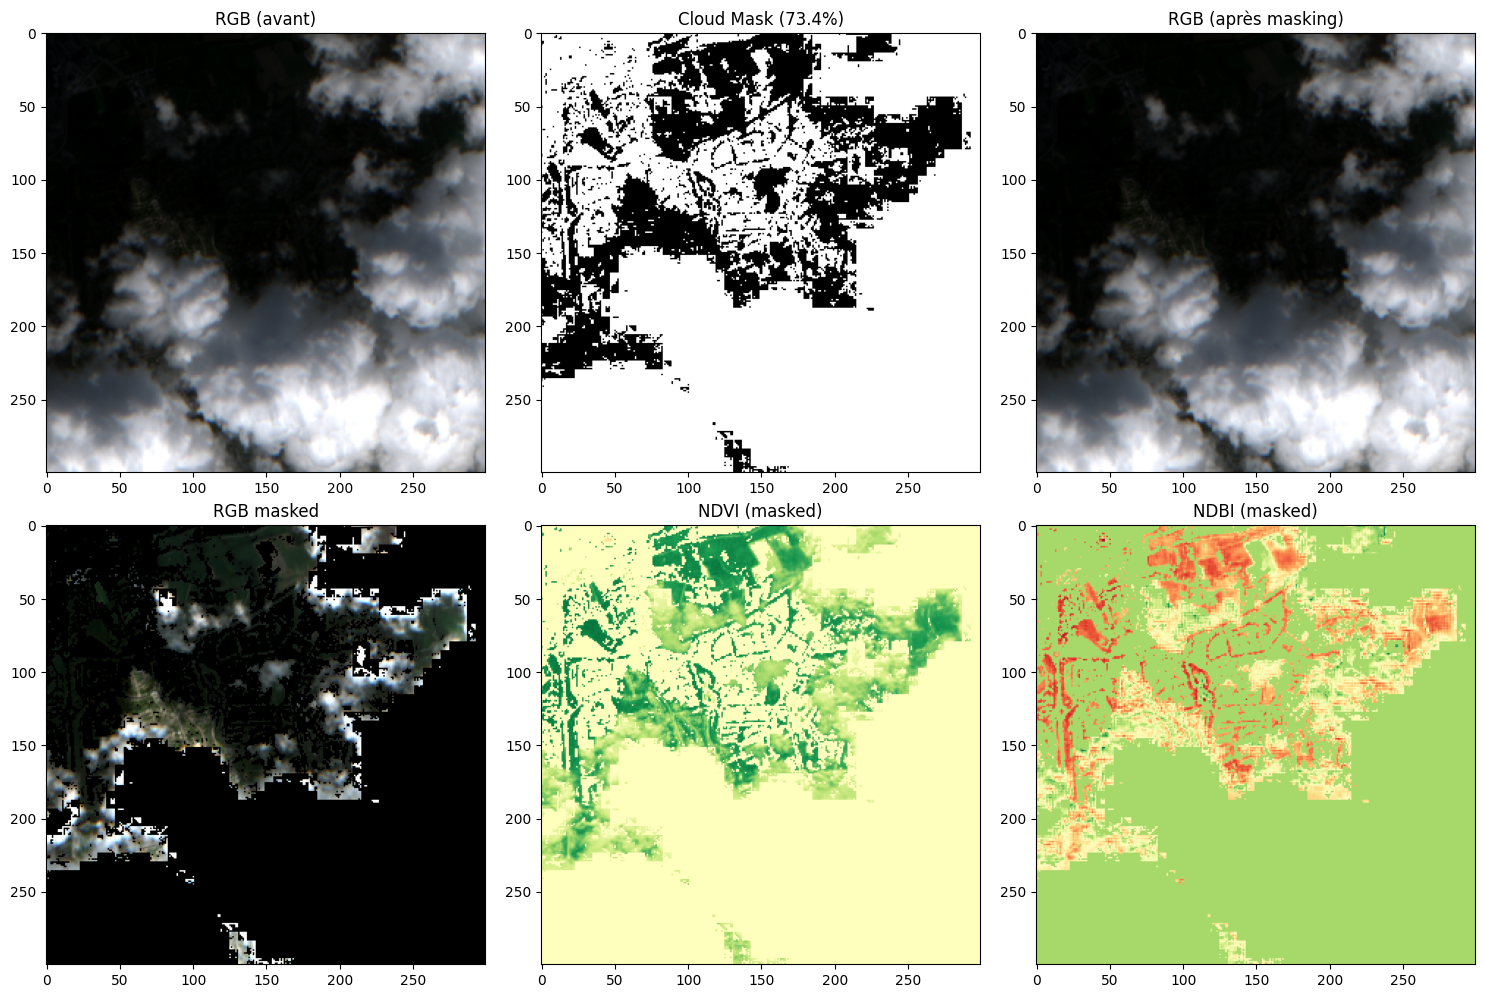

In [ ]:
from urban_watch.ml_logic.data import load_data
from urban_watch.ml_logic.package import CloudMasker, IndexCalculator, ImageNormalizer

# 1. Charge les données
X, meta = load_data()  # (10, 300, 300, 10)

# 2. Détecte les nuages
masker = CloudMasker(threshold=0.5, dilation_size=1)
masks = []
for i, img in enumerate(X):
    mask = masker.detect_clouds(img)
    masks.append(mask)
    pct = masker.get_cloud_percentage(mask)
    print(f"Tile {i}: {pct:.1f}% clouds")

# 3. Applique le masque (enlève les nuages)
img = X[2]
mask = masks[0]
img_masked = masker.apply_mask(img, mask, fill_value=0.0)  # ← Masking !

# 4. Calcule les indices sur l'image masquée
ndvi = IndexCalculator.ndvi(img_masked[:,:,3], img_masked[:,:,6])
ndbi = IndexCalculator.ndbi(img_masked[:,:,8], img_masked[:,:,6])
mndwi = IndexCalculator.mndwi(img_masked[:,:,2], img_masked[:,:,8])

# 5. Normalise pour visualisation
img_norm = ImageNormalizer.normalize_full(img_masked)

# 6. Affiche
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Avant masking
axes[0,0].imshow(ImageNormalizer.normalize_full(img)[:,:,[3,2,1]])
axes[0,0].set_title("RGB (avant)")
axes[0,1].imshow(mask, cmap='gray')
axes[0,1].set_title(f"Cloud Mask ({masker.get_cloud_percentage(mask):.1f}%)")
axes[0,2].imshow(ImageNormalizer.normalize_full(img)[:,:,[3,2,1]])
axes[0,2].set_title("RGB (après masking)")

# Indices après masking
axes[1,0].imshow(img_norm[:,:,[3,2,1]])
axes[1,0].set_title("RGB masked")
axes[1,1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1,1].set_title("NDVI (masked)")
axes[1,2].imshow(ndbi, cmap='RdYlGn')
axes[1,2].set_title("NDBI (masked)")

plt.tight_layout()
plt.show()

In [30]:
from urban_watch.ml_logic.package import preprocess_image
X_processed = np.array([preprocess_image(img) for img in X])


In [31]:
print("Shape before:", X.shape)
print("Shape after preprocessing:", X_processed.shape)

Shape before: (10, 300, 300, 10)
Shape after preprocessing: (10, 300, 300, 13)


In [32]:
X

array([[[[6.0000e-02, 1.0540e-01, 1.2500e-01, ..., 1.6290e-01,
          1.8710e-01, 1.7970e-01],
         [6.0000e-02, 1.0800e-01, 1.1960e-01, ..., 1.8070e-01,
          1.8430e-01, 1.5540e-01],
         [6.0000e-02, 6.9200e-02, 8.6000e-02, ..., 1.8070e-01,
          1.8430e-01, 1.5540e-01],
         ...,
         [5.6600e-02, 5.1500e-02, 8.8600e-02, ..., 2.9550e-01,
          2.8620e-01, 2.2540e-01],
         [5.6600e-02, 8.3300e-02, 1.1640e-01, ..., 2.9550e-01,
          2.8620e-01, 2.2540e-01],
         [5.6600e-02, 1.0640e-01, 1.4500e-01, ..., 2.7930e-01,
          3.3510e-01, 2.8100e-01]],

        [[6.0000e-02, 1.0980e-01, 1.2380e-01, ..., 1.6290e-01,
          1.8710e-01, 1.7970e-01],
         [6.0000e-02, 1.0860e-01, 1.1160e-01, ..., 1.8070e-01,
          1.8430e-01, 1.5540e-01],
         [6.0000e-02, 9.8800e-02, 1.1040e-01, ..., 1.8070e-01,
          1.8430e-01, 1.5540e-01],
         ...,
         [5.6600e-02, 7.3200e-02, 1.1140e-01, ..., 2.9550e-01,
          2.8620e-01, 2.2

In [ ]:
# Choisir une image traitée
img_std = X_processed[2]  # (300, 300, 13)

# Indices déjà ajoutés dans les 3 dernières bandes
ndvi  = img_std[:, :, -3]
ndbi  = img_std[:, :, -2]
mndwi = img_std[:, :, -1]

# RGB : on peut prendre les bandes Red, Green, Blue originales
# Elles ont été normalisées et standardisées dans X_processed
RGB = img_std[:, :, [3,2,1]]  # Red, Green, Blue

# Affichage
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0,0].imshow(RGB)
axes[0,0].set_title("RGB (processed)")
axes[0,0].axis('off')

axes[0,1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0,1].set_title("NDVI")
axes[0,1].axis('off')

axes[0,2].imshow(ndbi, cmap='RdYlGn')
axes[0,2].set_title("NDBI")
axes[0,2].axis('off')

axes[1,0].imshow(mndwi, cmap='Blues')
axes[1,0].set_title("MNDWI")
axes[1,0].axis('off')

# Tu peux répéter RGB ou zoom si tu veux remplir la grille
axes[1,1].imshow(RGB)
axes[1,1].set_title("RGB again")
axes[1,1].axis('off')

axes[1,2].imshow(RGB)
axes[1,2].set_title("RGB again")
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

n_tiles = X_processed.shape[0]

for i in range(n_tiles):
    img_std = X_processed[i]  # (H, W, 13)

    # Extraire RGB et indices
    RGB   = img_std[:, :, [3,2,1]]  # Red, Green, Blue
    ndvi  = img_std[:, :, -3]
    ndbi  = img_std[:, :, -2]
    mndwi = img_std[:, :, -1]

    # Création figure
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(RGB)
    axes[0].set_title(f"Tile {i} - RGB")
    axes[0].axis('off')

    axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1].set_title("NDVI")
    axes[1].axis('off')

    axes[2].imshow(ndbi, cmap='RdYlGn')
    axes[2].set_title("NDBI")
    axes[2].axis('off')

    axes[3].imshow(mndwi, cmap='Blues')
    axes[3].set_title("MNDWI")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

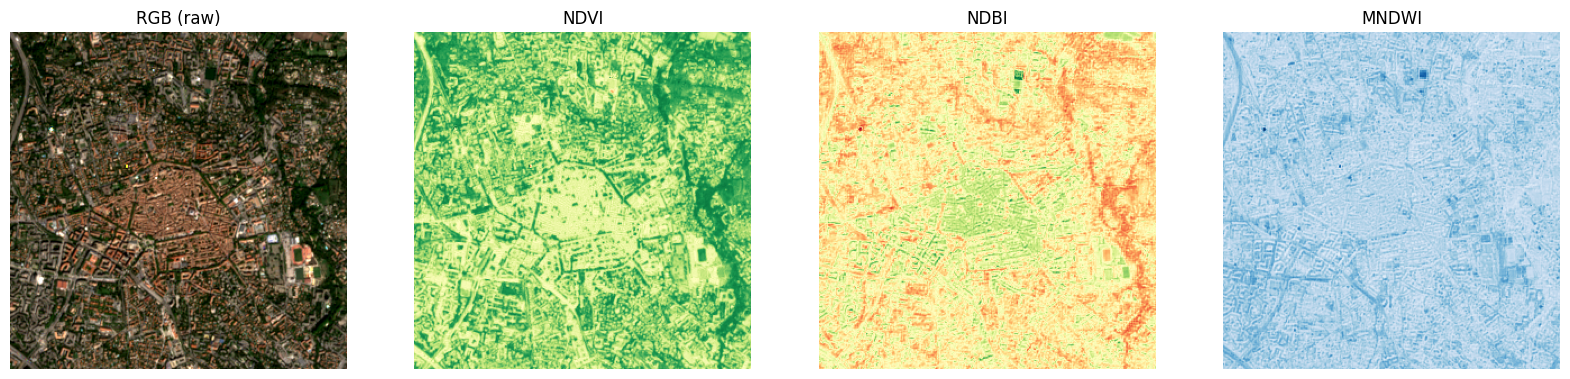

In [37]:
import numpy as np
import matplotlib.pyplot as plt

img_std = X_processed[0]  # exemple : première tuile

# RGB avant standardisation
RGB_raw = ImageNormalizer.normalize_full(X[0])[:, :, [3,2,1]]  # normalisation classique pour visualisation

# Indices (NDVI, NDBI, MNDWI) sans standardiser
ndvi  = IndexCalculator.ndvi(X[0][:,:,3], X[0][:,:,6])
ndbi  = IndexCalculator.ndbi(X[0][:,:,8], X[0][:,:,6])
mndwi = IndexCalculator.mndwi(X[0][:,:,2], X[0][:,:,8])

fig, axes = plt.subplots(1, 4, figsize=(20,5))
axes[0].imshow(RGB_raw)
axes[0].set_title("RGB (raw)")
axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_title("NDVI")
axes[2].imshow(ndbi, cmap='RdYlGn')
axes[2].set_title("NDBI")
axes[3].imshow(mndwi, cmap='Blues')
axes[3].set_title("MNDWI")
for ax in axes: ax.axis('off')
plt.show()
